In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
count = {}
for dirname, _, filenames in os.walk('/kaggle/input/deeplense-specific-data/lens-finding/train_lenses'):
    count['train_lenses']=[os.path.join('/kaggle/input/deeplense-specific-data/lens-finding/train_lenses',f) for f in filenames]
for dirname, _, filenames in os.walk('/kaggle/input/deeplense-specific-data/lens-finding/train_nonlenses'):
    count['train_nonlenses']=[os.path.join('/kaggle/input/deeplense-specific-data/lens-finding/train_nonlenses',f) for f in filenames]

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

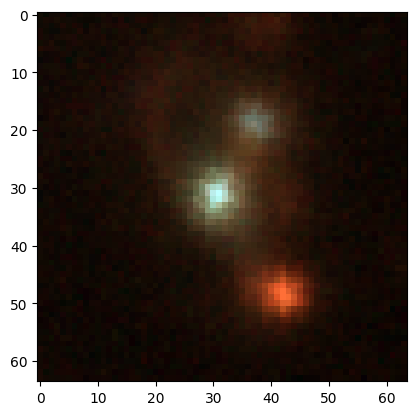

In [2]:
sample_l = np.load(count['train_lenses'][4])
plt.imshow(sample_l.transpose(1,2,0))

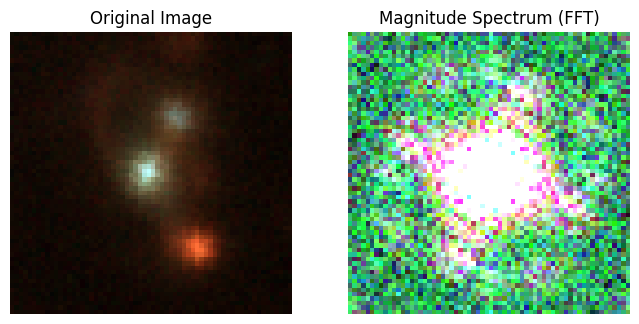

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the 2D FFT
fft_image = np.fft.fft2(sample_l)
fft_shifted = np.fft.fftshift(fft_image)

# Compute magnitude spectrum
magnitude_spectrum = np.log(1 + np.abs(fft_shifted))

# Visualize
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(sample_l.transpose(1,2,0))  # Original Image
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(magnitude_spectrum.transpose(1,2,0))  # Average across channels
plt.title("Magnitude Spectrum (FFT)")
plt.axis("off")

plt.show()

In [4]:
# train_l = np.concatenate([np.load(f) for f in count['train_lenses']])
# train_nl = np.concatenate([np.load(f) for f in count['train_nonlenses']])

In [5]:
# train_nl.shape

In [6]:
# Lens Classification Notebook
# A state-of-the-art, customizable PyTorch implementation for lens classification

import os
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler, TensorDataset
from torchvision import models, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
from tqdm.notebook import tqdm
import copy
import time
from transformers import AutoModel, AutoImageProcessor
import torch.nn.functional as F

# Setting the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set the seed for reproducibility (Cell 1)
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed()

# Configuration parameters (can be easily modified)
config = {
    'batch_size': 32,
    'num_epochs': 50,
    'learning_rate': 0.001,
    'val_split': 0.2,
    'seed': 42,
    'model_name': 'resnet50',  # Options: 'resnet18', 'crop_view' 'efficient_fft_attention' 'fftaugmented' 'efficient_attention' 'dinov2-variants', 'resnet50', 'efficientnet_b0', 'densenet121', 'custom_cnn'
    'freeze_backbone': False,
    'optimizer': 'adam',  # Options: 'adam', 'sgd', 'adamw'
    'scheduler': 'cosine',  # Options: 'step', 'cosine', 'none'
    'early_stopping_patience': 10,
    'weight_decay': 1e-4,
    'dropout_rate': 0,
    'img_size': 64,
    'save_path': './saved_models',
    'num_workers': 4,
    'augmentation_level': 'heavy',  # Options: 'none', 'light', 'medium', 'heavy'
    'rotation': 360,
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225],
    'use_attention': False,
    'loss_function': 'bce',  #Options: 'bce', 'pin', 'focal', 'tversky', 'focaltversky'
    'focal_alpha': (0.25, 0.75),
    'focal_gamma': 3.5,
    'tversky_alpha_beta': (0.3, 0.7),
    'focaltversky_a_b_g': (0.3, 0.7, 0.2),
    'einstien_check': False,
    'modified_relu': False,
    'weighted_sampling': False
}

Using device: cuda:0


In [7]:
# Custom Dataset class for loading .npy files (Cell 2)
set_seed(config['seed'])

class LensDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        """
        Args:
            file_paths (list): List of paths to .npy files
            labels (list): List of labels corresponding to file_paths
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        # Load the npy file
        image = np.load(self.file_paths[idx])
        
        # Convert to PyTorch tensor (C, H, W)
        image = torch.from_numpy(image).float()
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
        
        return image, self.labels[idx]

In [8]:
# Data loading and preprocessing function (Cell 3)
set_seed(config['seed'])

def prepare_data(train_lenses, train_nonlenses, config):
    """
    Prepare the datasets and dataloaders
    
    Args:
        train_lenses (list): List of file paths to lens data
        train_nonlenses (list): List of file paths to non-lens data
        config (dict): Configuration parameters
        
    Returns:
        train_loader, val_loader: DataLoader objects for training and validation
    """
    # Create file paths and labels lists
    all_file_paths = train_lenses + train_nonlenses
    all_labels = [1] * len(train_lenses) + [0] * len(train_nonlenses)
    
    # Define augmentations based on the selected level
    if config['augmentation_level'] == 'none':
        transform = transforms.Compose([
            transforms.Normalize(mean=config['mean'], std=config['std'])
        ])
    elif config['augmentation_level'] == 'light':
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Normalize(mean=config['mean'], std=config['std'])
        ])
    elif config['augmentation_level'] == 'medium':
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(config['rotation']),
            transforms.Normalize(mean=config['mean'], std=config['std'])
        ])
    else:  # heavy
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(config['rotation']),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.Normalize(mean=config['mean'], std=config['std'])
        ])
    
    # Create the full dataset
    if config['model_name'].startswith('dinov2'):
        full_dataset = LensDataset(all_file_paths, all_labels, transform=None)
    else:
        full_dataset = LensDataset(all_file_paths, all_labels, transform=transform)
    
    # Split into train and validation sets
    val_size = int(config['val_split'] * len(full_dataset))
    train_size = len(full_dataset) - val_size
    
    train_dataset, val_dataset = random_split(
        full_dataset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(config['seed'])
    )
    
    # Create data loaders
    
    if config['model_name'].startswith('dinov2'):
        train_loader = DataLoader(
            train_dataset, 
            batch_size=config['batch_size'], 
            shuffle=False, 
            num_workers=config['num_workers'],
            pin_memory=True
        )
        
    elif config['weighted_sampling']:
        labels = [full_dataset.labels[i] for i in train_dataset.indices]
        class_counts = np.bincount(labels)  # Count occurrences of 0s and 1s
        class_weights = 1.0 / class_counts  # Inverse of frequency
        sample_weights = torch.tensor([class_weights[label] for label in labels], dtype=torch.float)
        
        # Create sampler
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset.indices), replacement=True)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=config['batch_size'],
            sampler=sampler,
            num_workers=config['num_workers'],
            pin_memory=True
        )
    else:
        train_loader = DataLoader(
            train_dataset, 
            batch_size=config['batch_size'], 
            shuffle=True, 
            num_workers=config['num_workers'],
            pin_memory=True
        )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False, 
        num_workers=config['num_workers'],
        pin_memory=True
    )
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    return train_loader, val_loader

In [9]:
# Data visualization function (Cell 4)
set_seed(config['seed'])

def visualize_data(data_loader, num_images=5):
    """
    Visualize samples from the dataset
    
    Args:
        data_loader: DataLoader object to visualize samples from
        num_images (int): Number of images to visualize
    """
    # Get a batch of data
    images, labels = next(iter(data_loader))
    
    # Create a figure to display the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    
    # Display the images
    for i in range(num_images):
        if i < len(images):
            # Convert the tensor to a numpy array and transpose to (H, W, C) for display
            img = images[i].numpy()
            
            # Normalize the image for visualization
            img = (img - img.min()) / (img.max() - img.min())
            
            # Display the image
            axes[i].imshow(np.transpose(img, (1, 2, 0)))
            axes[i].set_title(f"Class: {'Lens' if labels[i] == 1 else 'Non-Lens'}")
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Plot class distribution
    all_labels = []
    for _, batch_labels in data_loader:
        all_labels.extend(batch_labels.numpy())
    
    # Count labels
    unique_labels, counts = np.unique(all_labels, return_counts=True)
    
    # Plot class distribution
    plt.figure(figsize=(8, 5))
    plt.bar(['Non-Lens', 'Lens'], [counts[0], counts[1]], color=['skyblue', 'salmon'])
    plt.title('Class Distribution')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [10]:
set_seed(config['seed'])

class DINOv2Embedder(nn.Module):
    """
    DINOv2 model for feature extraction
    """
    def __init__(self, config):
        super().__init__()
        self.processor = AutoImageProcessor.from_pretrained(f"facebook/{config['model_name']}")
        self.model = AutoModel.from_pretrained(f"facebook/{config['model_name']}")
        
        # Freeze the backbone if specified
        for param in self.model.parameters():
            param.requires_grad = False
                
        # Store the embedding dimension for downstream tasks
        self.embedding_dim = self.model.config.hidden_size
    
    def forward(self, x):
        """
        Forward pass without classification head - just returns embeddings
        """
        inputs = self.processor(images=x, return_tensors="pt").to(x.device)
        outputs = self.model(**inputs)
        # Extract CLS token embedding
        embeddings = outputs.last_hidden_state[:, 0, :]
        return embeddings
    
    def get_embeddings(self, x):
        """
        Explicit method to get embeddings (same as forward, but more explicit)
        """
        return self.forward(x)


class EmbeddingClassifier(nn.Module):
    """
    Classifier model that works with DINOv2 embeddings
    """
    def __init__(self, config, embedding_dim):
        super().__init__()
        
        # Simple classifier with optional multi-head output
        self.use_multi_head = config.get('use_multi_head', False)
        self.dropout_rate = config.get('dropout_rate', 0.2)
        
        if self.use_multi_head:
            # Main classification head
            self.main_head = nn.Sequential(
                nn.Dropout(self.dropout_rate),
                nn.Linear(embedding_dim, 1),
                nn.Sigmoid()
            )
            
            # Auxiliary head for Einstein Ring Classification (erc)
            self.aux_head = nn.Sequential(
                nn.Dropout(self.dropout_rate),
                nn.Linear(embedding_dim, 1),
                nn.Sigmoid()
            )
        else:
            # Single classification head
            self.fc = nn.Sequential(
                nn.Dropout(self.dropout_rate),
                nn.Linear(embedding_dim, 1),
                nn.Sigmoid()
            )
    
    def forward(self, x):
        """
        Forward pass that takes embeddings and returns classification
        """
        if self.use_multi_head:
            main_output = self.main_head(x)
            aux_output = self.aux_head(x)
            return (main_output, aux_output)
        else:
            return self.fc(x)


# Helper function to create both models
def create_dinov2_classifier(config):
    """
    Create both DINOv2 embedder and classifier models
    
    Args:
        config (dict): Configuration parameters
        
    Returns:
        dinov2_model (nn.Module): DINOv2 embedder model
        classifier_model (nn.Module): Classifier model
    """
    # Create DINOv2 embedder
    dinov2_model = DINOv2Embedder(config)
    
    # Create classifier that takes embeddings as input
    classifier_model = EmbeddingClassifier(
        config, 
        embedding_dim=dinov2_model.embedding_dim
    )
    
    return dinov2_model, classifier_model

In [11]:
class efficient_attention(nn.Module):
    def __init__(self, num_classes=1, use_attention=True):
        super().__init__()
        # Backbone: EfficientNet-B0
        self.backbone = models.efficientnet_b0(pretrained=True).features
        self.use_attention = use_attention
        
        # Physics-Guided Attention
        if self.use_attention:
            self.radial_mask = self._create_radial_mask(64)  # For input size 64x64
            self.channel_att = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(3, 16, 1), nn.ReLU(),
                nn.Conv2d(16, 3, 1), nn.Sigmoid()
            )
        
        # Classification & Regression Heads
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(config['dropout_rate']),
            nn.Linear(1280, num_classes),
            nn.Sigmoid()
        )
        self.radius_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(config['dropout_rate']),
            nn.Linear(1280, 1)
        )

    def _create_radial_mask(self, size):
        """Fixed Gaussian mask to focus on central regions"""
        xx, yy = torch.meshgrid(torch.arange(size), torch.arange(size))
        mask = torch.exp(-((xx - size//2)**2 + (yy - size//2)**2)/(2*(size//4)**2))
        return mask.unsqueeze(0)  # Shape: (1, H, W)

    def forward(self, x):
        # Apply attention
        if self.use_attention:
            x = x * self.radial_mask.to(x.device)  # Radial bias
            channel_weights = self.channel_att(x)
            x = x * channel_weights
        
        # Backbone features
        features = self.backbone(x)
        
        # Outputs
        cls_logits = self.classifier(features)
        radius = self.radius_head(features)
        return cls_logits, radius

In [12]:
class FFTAugmentedModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Spatial branch (original RGB)
        self.spatial_branch = models.efficientnet_b0(pretrained=True).features
        
        # Frequency branch (FFT magnitudes)
        self.freq_branch = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Dropout(config['dropout_rate']),
            nn.Linear(4*1280 + 32*32*32, 1),
            nn.Sigmoid()
        )  # Adjust dimensions

    def forward(self, x):
        # Spatial features
        spatial_feat = self.spatial_branch(x)
        
        
        # Frequency features
        fft = torch.fft.fft2(x, dim=(-2, -1))
        fft_mag = torch.log(1 + torch.abs(fft))  # Log-scale magnitudes
        freq_feat = self.freq_branch(fft_mag)
        
        # Concatenate & classify
        combined = torch.cat([spatial_feat.flatten(1), 
                             freq_feat.flatten(1)], dim=1)
        
        return self.classifier(combined)

In [13]:
class efficient_fft_attention(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        # Backbone: EfficientNet-B0
        self.backbone = models.efficientnet_b0(pretrained=True).features
        
        # Physics-Guided Attention
        self.channel_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(3, 16, 1), nn.ReLU(),
            nn.Conv2d(16, 3, 1), nn.Sigmoid()
        )
        
        # Classification & Regression Heads
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(config['dropout_rate']),
            nn.Linear(1280, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Apply attention
        fft = torch.fft.fft2(x, dim=(-2, -1))
        fft_mag = torch.log(1 + torch.abs(fft))
        channel_weights = self.channel_att(fft_mag)
        x = x * channel_weights
        
        # Backbone features
        features = self.backbone(x)
        
        # Outputs
        cls_logits = self.classifier(features)
        return cls_logits

In [14]:

class crop_view(nn.Module):
    def __init__(self):
        super().__init__()
        # Full-image branch (64x64 input)
        self.full_net = self._build_effnet()
        
        # Center-crop branch (32x32 input)
        self.crop_net = self._build_effnet()
        
        # Classifier (combines both branches)
        self.classifier = nn.Sequential(
            nn.Linear(2560, 512),  # 1280 (full) + 1280 (crop) = 2560
            nn.ReLU(),
            nn.Dropout(config['dropout_rate']),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def _build_effnet(self):
        """EfficientNet-B0 without classifier + adjusted for small inputs"""
        model = models.efficientnet_b0(pretrained=False)
        model.classifier = nn.Identity()  # Remove final FC layer
        
        # Modify stem convolution for smaller inputs
        model.features[0][0] = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        return model

    def forward(self, x):
        # Full-image branch
        full_feat = self.full_net(x)
        
        # Center crop (32x32 from 64x64 input)
        _, _, H, W = x.shape
        x_crop = x[:, :, H//4:3*H//4, W//4:3*W//4]  # Center 32x32
        
        # Crop branch
        crop_feat = self.crop_net(x_crop)
        
        # Combine and classify
        combined = torch.cat([full_feat, crop_feat], dim=1)
        return self.classifier(combined)

In [15]:
class ModifiedReLU(nn.Module):
    def forward(self, x):
        return (1 / torch.sqrt(torch.tensor(torch.pi - 1))) * (torch.sqrt(2 * torch.tensor(torch.pi)) * torch.relu(x) - 1)

In [16]:
def replace_activation(model, new_activation):
    for name, module in model.named_children():
        if isinstance(module, (nn.SiLU, nn.ReLU)):  
            setattr(model, name, new_activation)
        else:
            replace_activation(module, new_activation)
    return model

In [17]:
# Model definition function (Cell 5)
set_seed(config['seed'])

def create_model(config):
    """
    Create a model based on the configuration
    
    Args:
        config (dict): Configuration parameters
        
    Returns:
        model (nn.Module): The created model
    """
    if config['model_name'] == 'resnet18':
        model = models.resnet18(weights='DEFAULT')
        if config['freeze_backbone']:
            for param in model.parameters():
                param.requires_grad = False
        # Modify the final layer for binary classification
        model.fc = nn.Sequential(
            nn.Dropout(config['dropout_rate']),
            nn.Linear(model.fc.in_features, 1),
            nn.Sigmoid()
        )

    elif config['model_name'].startswith('dinov2'):
        model = create_dinov2_classifier(config)

    elif config['model_name'] == 'efficient_attention':
        model = efficient_attention(use_attention = config['use_attention'])

    elif config['model_name'] == 'fftaugmented':
        model = FFTAugmentedModel()

    elif config['model_name'] == 'efficient_fft_attention':
        model = efficient_fft_attention()

    elif config['model_name'] == 'crop_view':
        model = crop_view()
    
    elif config['model_name'] == 'resnet50':
        model = models.resnet50(weights='DEFAULT')
        if config['freeze_backbone']:
            for param in model.parameters():
                param.requires_grad = False
        # Modify the final layer
        model.fc = nn.Sequential(
            nn.Dropout(config['dropout_rate']),
            nn.Linear(model.fc.in_features, 1),
            nn.Sigmoid()
        )
    
    elif config['model_name'] == 'efficientnet_b0':
        model = models.efficientnet_b0(weights='DEFAULT')
        if config['freeze_backbone']:
            for param in model.parameters():
                param.requires_grad = False
        # Modify the classifier
        model.classifier = nn.Sequential(
            nn.Dropout(config['dropout_rate']),
            nn.Linear(model.classifier[1].in_features, 1),
            nn.Sigmoid()
        )
    
    elif config['model_name'] == 'densenet121':
        model = models.densenet121(weights='DEFAULT')
        if config['freeze_backbone']:
            for param in model.parameters():
                param.requires_grad = False
        # Modify the classifier
        model.classifier = nn.Sequential(
            nn.Dropout(config['dropout_rate']),
            nn.Linear(model.classifier.in_features, 1),
            nn.Sigmoid()
        )
    
    elif config['model_name'] == 'custom_cnn':
        # Define a custom CNN architecture
        model = nn.Sequential(
            # Input shape: (3, 64, 64)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32, 32, 32)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 16, 16)
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 8, 8)
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 4, 4)
            
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(config['dropout_rate']),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    else:
        raise ValueError(f"Model {config['model_name']} not supported")

    if config['modified_relu']:
        model = (model[0], replace_activation(model[1], ModifiedReLU())) if type(model)==tuple else replace_activation(model, ModifiedReLU())
    
    # Move model to device
    model = (model[0].to(device), model[1].to(device)) if type(model)==tuple else model.to(device)
    print(f"Created {config['model_name']} model")
    
    return model

In [18]:
# Define optimizer and scheduler (Cell 6)
set_seed(config['seed'])

def get_optimizer_and_scheduler(model, config):
    """
    Create an optimizer and learning rate scheduler based on the configuration
    
    Args:
        model (nn.Module): The model to optimize
        config (dict): Configuration parameters
        
    Returns:
        optimizer, scheduler: The created optimizer and scheduler
    """
    # Create optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(
            model.parameters(), 
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
    elif config['optimizer'] == 'sgd':
        optimizer = optim.SGD(
            model.parameters(), 
            lr=config['learning_rate'],
            momentum=0.9,
            weight_decay=config['weight_decay']
        )
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(
            model.parameters(),
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
    else:
        raise ValueError(f"Optimizer {config['optimizer']} not supported")
    
    # Create scheduler
    if config['scheduler'] == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    elif config['scheduler'] == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['num_epochs'])
    elif config['scheduler'] == 'none':
        scheduler = None
    else:
        raise ValueError(f"Scheduler {config['scheduler']} not supported")
    
    return optimizer, scheduler

In [19]:
class PhysicsAwareLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.1):
        super().__init__()
        self.focal_loss = nn.BCELoss()  # Handle class imbalance
        self.alpha = alpha  # Weight for radius penalty
        # self.beta = beta    # Weight for asymmetry loss
        
    def forward(self, outputs, targets):
        cls_logits, radius_pred = outputs
        cls_loss = self.focal_loss(cls_logits, targets)
        
        # Radius constraint (valid range: 0.5-5 arcseconds)
        radius_penalty = torch.mean(
            torch.clamp(radius_pred - 5, min=0) + 
            torch.clamp(0.5 - radius_pred, min=0)
        )
        
        # # Asymmetry loss (using Sobel filters)
        # sobel_x = torch.tensor([[[[-1,0,1], [-2,0,2], [-1,0,1]]]], dtype=torch.float32)
        # sobel_y = torch.tensor([[[[-1,-2,-1], [0,0,0], [1,2,1]]]], dtype=torch.float32)
        # grad_x = torch.abs(nn.functional.conv2d(features, sobel_x.to(features.device)))
        # grad_y = torch.abs(nn.functional.conv2d(features, sobel_y.to(features.device)))
        # asymmetry = torch.mean((grad_x - grad_y)**2)
        
        total_loss = (cls_loss + 
                     self.alpha * radius_penalty)
                     # self.beta * asymmetry)
        return total_loss

In [20]:
def erc(r):
    if config['einstien_check']:
        return (r >= 0.5) & (r <= 5)
    else:
        return r==r

In [21]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=(0.5, 0.5), gamma=2.0, reduction='mean'):
        """
        alpha: Tuple (alpha_neg, alpha_pos) for class balancing
        gamma: Focusing parameter (higher -> more focus on hard examples)
        reduction: 'mean' or 'sum'
        """
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha)  # Convert tuple to tensor
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # Probability of correct class
        alpha_t = self.alpha[1] * targets + self.alpha[0] * (1 - targets)  # Select alpha for each sample
        
        focal_loss = alpha_t * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss  # No reduction

In [22]:
class TverskyLoss(nn.Module):
    def __init__(self):
        super(TverskyLoss, self).__init__()
        self.alpha = config['tversky_alpha_beta'][0]  # Penalizes false negatives
        self.beta = config['tversky_alpha_beta'][1]    # Penalizes false positives (increase for higher precision)

    def forward(self, inputs, targets, smooth=1e-6):
        inputs = inputs.sigmoid()  # Ensure probability range
        TP = (inputs * targets).sum()
        FP = ((1 - targets) * inputs).sum()
        FN = (targets * (1 - inputs)).sum()
        loss = 1 - (TP + smooth) / (TP + self.alpha * FN + self.beta * FP + smooth)
        return loss.mean()

In [23]:
class FocalTverskyLoss(nn.Module):
    def __init__(self):
        super(FocalTverskyLoss, self).__init__()
        self.alpha = config['focaltversky_a_b_g'][0]
        self.beta = config['focaltversky_a_b_g'][1]
        self.gamma = config['focaltversky_a_b_g'][2]

    def forward(self, inputs, targets, smooth=1e-6):
        inputs = inputs.sigmoid()
        TP = (inputs * targets).sum()
        FP = ((1 - targets) * inputs).sum()
        FN = (targets * (1 - inputs)).sum()
        tversky_index = (TP + smooth) / (TP + self.alpha * FN + self.beta * FP + smooth)
        focal_tversky_loss = (1 - tversky_index) ** self.gamma
        return focal_tversky_loss.mean()

In [24]:
# Training function (Cell 7)
set_seed(config['seed'])

def train_model(model, train_loader, val_loader, config):
    """
    Train the model
    
    Args:
        model (nn.Module): The model to train
        train_loader (DataLoader): DataLoader for training data
        val_loader (DataLoader): DataLoader for validation data
        config (dict): Configuration parameters
        
    Returns:
        model (nn.Module): The trained model
        history (dict): Training history
    """
    # Create optimizer and scheduler
    optimizer, scheduler = get_optimizer_and_scheduler(model, config)
    
    # Define loss function
    if config['loss_function'] == 'bce':
        criterion = nn.BCELoss()
        print('Using bce loss')

    elif config['loss_function'] == 'focal':
        alpha = config['focal_alpha'] # (~0.057, ~0.943)
        gamma = config['focal_gamma']  # Standard choice
        
        criterion = FocalLoss(alpha=alpha, gamma=gamma)

        print(f'Using focal loss with alpha {alpha} and gamma {gamma}')

    elif config['loss_function'] == 'tversky':
        
        criterion = TverskyLoss()

        print(f"Using focaltversky loss with a_b {config['tversky_alpha_beta']}")

    elif config['loss_function'] == 'focaltversky':
        
        criterion = FocalTverskyLoss()

        print(f"Using focaltversky loss with a_b_g {config['focaltversky_a_b_g']}")

    elif config['loss_function'] == 'pin':
        criterion = PhysicsAwareLoss()
        print('Using pin loss')
    
    # Initialize the best model weights and validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_auc = 0.0
    best_epoch = 0
    patience_counter = 0
    
    # Initialize history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'val_roc_auc': []  # Added ROC AUC metric
    }
    
    # Training loop
    for epoch in range(config['num_epochs']):
        print(f'Epoch {epoch+1}/{config["num_epochs"]}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over the training data
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.float().to(device).view(-1, 1)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Backward pass + optimize
                loss.backward()
                optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            preds = ((outputs[0] > 0.5) & erc(outputs[1])).float() if type(outputs)==tuple else (outputs > 0.5).float()
            running_corrects += torch.sum(preds == labels)
        
        if scheduler is not None:
            scheduler.step()
        
        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_preds = []
        val_labels = []
        val_scores = []  # Added for ROC AUC calculation
        
        # Iterate over the validation data
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs = inputs.to(device)
            labels = labels.float().to(device).view(-1, 1)
            
            # Forward pass
            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            # Statistics
            val_running_loss += loss.item() * inputs.size(0)
            preds = ((outputs[0] > 0.5) & erc(outputs[1])).float() if type(outputs)==tuple else (outputs > 0.5).float()
            
            # Collect predictions, raw scores, and labels for metrics
            val_preds.extend(preds.cpu().numpy())
            val_scores.extend(outputs[0].cpu().numpy() if type(outputs)==tuple else outputs.cpu().numpy())  # Raw scores for ROC AUC
            val_labels.extend(labels.cpu().numpy())
        
        # Calculate validation statistics
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_preds = np.array(val_preds).flatten()
        val_scores = np.array(val_scores).flatten()  # Convert to numpy array
        val_labels = np.array(val_labels).flatten()
        
        val_acc = accuracy_score(val_labels, val_preds)
        val_precision = precision_score(val_labels, val_preds, zero_division=0)
        val_recall = recall_score(val_labels, val_preds, zero_division=0)
        val_f1 = f1_score(val_labels, val_preds, zero_division=0)
        
        # Calculate ROC AUC
        from sklearn.metrics import roc_auc_score
        val_roc_auc = roc_auc_score(val_labels, val_scores)
        
        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_acc:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f} F1: {val_f1:.4f} ROC AUC: {val_roc_auc:.4f}')
        
        # Update history
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)
        history['val_roc_auc'].append(val_roc_auc)  # Add ROC AUC to history
        
        # If validation accuracy improved, save the model weights
        if val_roc_auc > best_val_auc:
            best_val_auc = val_roc_auc
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= config['early_stopping_patience']:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break
            
        print()
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    print(f'Best validation auc: {best_val_auc:.4f} achieved at epoch {best_epoch+1}')
    
    return model, history

In [25]:
# Evaluation function (Cell 8)
set_seed(config['seed'])
def evaluate_model(model, data_loader):
    """
    Evaluate the model on the given data loader
    Args:
        model (nn.Module): The model to evaluate
        data_loader (DataLoader): DataLoader for evaluation data
    Returns:
        metrics (dict): Evaluation metrics
    """
    model.eval()
    all_preds = []
    all_scores = []  # Added to store raw prediction scores
    all_labels = []
    # Collect predictions and labels
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            # Forward pass
            outputs = model(inputs)
            preds = ((outputs[0] > 0.5) & erc(outputs[1])).float() if type(outputs)==tuple else (outputs > 0.5).float()
            # Collect predictions, raw scores, and labels
            all_preds.extend(preds.cpu().numpy())
            all_scores.extend(outputs[0].cpu().numpy() if type(outputs)==tuple else outputs.cpu().numpy())  # Save raw scores for ROC AUC
            all_labels.extend(labels.numpy())
    # Convert to numpy arrays
    all_preds = np.array(all_preds).flatten()
    all_scores = np.array(all_scores).flatten()
    all_labels = np.array(all_labels)
    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    # Calculate ROC AUC
    from sklearn.metrics import roc_auc_score, roc_curve, auc
    roc_auc = roc_auc_score(all_labels, all_scores)
    # Print results
    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    # Create figure with subplots
    plt.figure(figsize=(15, 6))
    # Plot confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Lens', 'Lens'],
                yticklabels=['Non-Lens', 'Lens'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    # Plot ROC curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    # Return metrics
    metrics = {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,  # Added ROC AUC to metrics
        'confusion_matrix': cm
    }
    return metrics

In [26]:
set_seed(config['seed'])

def extract_dinov2_embeddings(model, data_loader):
    """
    Extract DINOv2 embeddings for all samples in the data loader
    
    Args:
        model (nn.Module): The DINOv2 model
        data_loader (DataLoader): DataLoader containing the data
        device (torch.device): Device to use for computation
        
    Returns:
        embeddings (torch.Tensor): Extracted embeddings
        labels (torch.Tensor): Corresponding labels
    """
    model.eval()
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Extracting DINOv2 embeddings"):
            inputs = inputs.to(device)
            # Get embeddings from DINOv2
            embeddings = model.get_embeddings(inputs)
            
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels)
    
    return torch.cat(all_embeddings), torch.cat(all_labels)

def train_model_with_dinov2(dinov2_model, classifier_model, train_loader, val_loader, config):
    """
    Train the model using pre-computed DINOv2 embeddings
    
    Args:
        dinov2_model (nn.Module): The DINOv2 model for extracting embeddings
        classifier_model (nn.Module): The classifier model to train
        train_loader (DataLoader): DataLoader for training data
        val_loader (DataLoader): DataLoader for validation data
        config (dict): Configuration parameters
        device (torch.device): Device to use for computation
        
    Returns:
        model (nn.Module): The trained classifier model
        history (dict): Training history
    """
    # Set seed for reproducibility
    set_seed(config['seed'])
    
    print("Extracting DINOv2 embeddings...")
    # Extract DINOv2 embeddings for training and validation sets
    train_embeddings, train_labels = extract_dinov2_embeddings(dinov2_model, train_loader)
    val_embeddings, val_labels = extract_dinov2_embeddings(dinov2_model, val_loader)
    
    # Create new data loaders with the extracted embeddings
    train_dataset = TensorDataset(train_embeddings, train_labels)
    val_dataset = TensorDataset(val_embeddings, val_labels)
    
    if config.get('weighted_sampling', False):
        # Convert labels to numpy for counting
        labels_np = train_labels.numpy().flatten()
        class_counts = np.bincount(labels_np.astype(int))  # Count occurrences of 0s and 1s
        class_weights = 1.0 / class_counts  # Inverse of frequency
        sample_weights = torch.tensor([class_weights[int(label)] for label in labels_np], dtype=torch.float)
        
        # Create weighted sampler
        sampler = WeightedRandomSampler(
            sample_weights, 
            num_samples=len(train_labels), 
            replacement=True
        )
        
        train_emb_loader = DataLoader(
            train_dataset,
            batch_size=train_loader.batch_size,
            sampler=sampler,  # Use sampler instead of shuffle
            num_workers=train_loader.num_workers if hasattr(train_loader, 'num_workers') else 0,
            pin_memory=True
        )
    else:
        # Standard DataLoader with shuffling if no weighted sampling
        train_emb_loader = DataLoader(
            train_dataset,
            batch_size=train_loader.batch_size,
            shuffle=True,
            num_workers=train_loader.num_workers if hasattr(train_loader, 'num_workers') else 0,
            pin_memory=True
        )
    
    val_emb_loader = DataLoader(
        val_dataset,
        batch_size=val_loader.batch_size,
        shuffle=False,
        num_workers=val_loader.num_workers if hasattr(val_loader, 'num_workers') else 0,
        pin_memory = True
    )
    
    # Create optimizer and scheduler
    optimizer, scheduler = get_optimizer_and_scheduler(classifier_model, config)
    
    # Define loss function
    if config['loss_function'] == 'bce':
        criterion = nn.BCELoss()
        print('Using bce loss')

    elif config['loss_function'] == 'focal':
        alpha = config['focal_alpha'] # (~0.057, ~0.943)
        gamma = config['focal_gamma']  # Standard choice
        
        criterion = FocalLoss(alpha=alpha, gamma=gamma)

        print(f'Using focal loss with alpha {alpha} and gamma {gamma}')

    elif config['loss_function'] == 'tversky':
        
        criterion = TverskyLoss()

        print(f"Using focaltversky loss with a_b {config['tversky_alpha_beta']}")

    elif config['loss_function'] == 'focaltversky':
        
        criterion = FocalTverskyLoss()

        print(f"Using focaltversky loss with a_b_g {config['focaltversky_a_b_g']}")

    elif config['loss_function'] == 'pin':
        criterion = PhysicsAwareLoss()
        print('Using pin loss')
    
    # Initialize the best model weights and validation accuracy
    best_model_wts = copy.deepcopy(classifier_model.state_dict())
    best_val_auc = 0.0
    best_epoch = 0
    patience_counter = 0
    
    # Initialize history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'val_roc_auc': []  # Added ROC AUC metric
    }
    
    # Training loop
    for epoch in range(config['num_epochs']):
        print(f'Epoch {epoch+1}/{config["num_epochs"]}')
        print('-' * 10)
        
        # Training phase
        classifier_model.train()
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over the training embeddings
        for embeddings, labels in tqdm(train_emb_loader, desc="Training"):
            embeddings = embeddings.to(device)
            labels = labels.float().to(device).view(-1, 1)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = classifier_model(embeddings)
                loss = criterion(outputs, labels)
                
                # Backward pass + optimize
                loss.backward()
                optimizer.step()
            
            # Statistics
            running_loss += loss.item() * embeddings.size(0)
            preds = ((outputs[0] > 0.5) & erc(outputs[1])).float() if type(outputs)==tuple else (outputs > 0.5).float()
            running_corrects += torch.sum(preds == labels)
        
        if scheduler is not None:
            scheduler.step()
        
        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_emb_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_emb_loader.dataset)
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        classifier_model.eval()
        val_running_loss = 0.0
        val_preds = []
        val_labels_list = []
        val_scores = []  # Added for ROC AUC calculation
        
        # Iterate over the validation embeddings
        for embeddings, labels in tqdm(val_emb_loader, desc="Validation"):
            embeddings = embeddings.to(device)
            labels = labels.float().to(device).view(-1, 1)
            
            # Forward pass
            with torch.no_grad():
                outputs = classifier_model(embeddings)
                loss = criterion(outputs, labels)
            
            # Statistics
            val_running_loss += loss.item() * embeddings.size(0)
            preds = ((outputs[0] > 0.5) & erc(outputs[1])).float() if type(outputs)==tuple else (outputs > 0.5).float()
            
            # Collect predictions, raw scores, and labels for metrics
            val_preds.extend(preds.cpu().numpy())
            val_scores.extend(outputs[0].cpu().numpy() if type(outputs)==tuple else outputs.cpu().numpy())  # Raw scores for ROC AUC
            val_labels_list.extend(labels.cpu().numpy())
        
        # Calculate validation statistics
        val_epoch_loss = val_running_loss / len(val_emb_loader.dataset)
        val_preds = np.array(val_preds).flatten()
        val_scores = np.array(val_scores).flatten()  # Convert to numpy array
        val_labels_np = np.array(val_labels_list).flatten()
        
        val_acc = accuracy_score(val_labels_np, val_preds)
        val_precision = precision_score(val_labels_np, val_preds, zero_division=0)
        val_recall = recall_score(val_labels_np, val_preds, zero_division=0)
        val_f1 = f1_score(val_labels_np, val_preds, zero_division=0)
        
        # Calculate ROC AUC
        val_roc_auc = roc_auc_score(val_labels_np, val_scores)
        
        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_acc:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f} F1: {val_f1:.4f} ROC AUC: {val_roc_auc:.4f}')
        
        # Update history
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)
        history['val_roc_auc'].append(val_roc_auc)  # Add ROC AUC to history
        
        # If validation AUC improved, save the model weights
        if val_roc_auc > best_val_auc:
            best_val_auc = val_roc_auc
            best_model_wts = copy.deepcopy(classifier_model.state_dict())
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= config['early_stopping_patience']:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break
            
        print()
    
    # Load best model weights
    classifier_model.load_state_dict(best_model_wts)
    print(f'Best validation AUC: {best_val_auc:.4f} achieved at epoch {best_epoch+1}')
    
    return classifier_model, history

In [27]:
set_seed(config['seed'])

def evaluate_model_with_dinov2(dinov2_model, classifier_model, data_loader):
    """
    Evaluate the model using DINOv2 embeddings on the given data loader
    
    Args:
        dinov2_model (nn.Module): The DINOv2 model for extracting embeddings
        classifier_model (nn.Module): The classifier model to evaluate
        data_loader (DataLoader): DataLoader for evaluation data
        device (torch.device): Device to use for computation
        
    Returns:
        metrics (dict): Evaluation metrics
    """
    # Set seed for reproducibility
    set_seed(config['seed'])
    
    print("Extracting DINOv2 embeddings for evaluation...")
    # Extract embeddings from DINOv2 model
    dinov2_model.eval()
    all_embeddings = []
    all_labels = []
    
    # Extract embeddings
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Extracting embeddings"):
            inputs = inputs.to(device)
            # Get embeddings from DINOv2
            embeddings = dinov2_model.get_embeddings(inputs)
            
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels)
    
    embeddings_tensor = torch.cat(all_embeddings)
    labels_tensor = torch.cat(all_labels)
    
    # Create a new dataset and dataloader with the embeddings
    embedding_dataset = TensorDataset(embeddings_tensor, labels_tensor)
    embedding_loader = DataLoader(
        embedding_dataset,
        batch_size=data_loader.batch_size,
        shuffle=False,
        num_workers=data_loader.num_workers if hasattr(data_loader, 'num_workers') else 0
    )
    
    # Evaluate on the embeddings
    classifier_model.eval()
    all_preds = []
    all_scores = []  # Added to store raw prediction scores
    all_labels_list = []
    
    # Collect predictions and labels
    with torch.no_grad():
        for embeddings, labels in tqdm(embedding_loader, desc="Evaluating"):
            embeddings = embeddings.to(device)
            
            # Forward pass
            outputs = classifier_model(embeddings)
            preds = ((outputs[0] > 0.5) & erc(outputs[1])).float() if type(outputs)==tuple else (outputs > 0.5).float()
            
            # Collect predictions, raw scores, and labels
            all_preds.extend(preds.cpu().numpy())
            all_scores.extend(outputs[0].cpu().numpy() if type(outputs)==tuple else outputs.cpu().numpy())  # Save raw scores for ROC AUC
            all_labels_list.extend(labels.numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds).flatten()
    all_scores = np.array(all_scores).flatten()
    all_labels_np = np.array(all_labels_list)
    
    # Calculate metrics
    acc = accuracy_score(all_labels_np, all_preds)
    precision = precision_score(all_labels_np, all_preds, zero_division=0)
    recall = recall_score(all_labels_np, all_preds, zero_division=0)
    f1 = f1_score(all_labels_np, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels_np, all_preds)
    
    # Calculate ROC AUC
    roc_auc = roc_auc_score(all_labels_np, all_scores)
    
    # Print results
    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    
    # Create figure with subplots
    plt.figure(figsize=(15, 6))
    
    # Plot confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Lens', 'Lens'],
                yticklabels=['Non-Lens', 'Lens'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    
    # Plot ROC curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(all_labels_np, all_scores)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()
    
    # Return metrics
    metrics = {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,  # Added ROC AUC to metrics
        'confusion_matrix': cm
    }
    
    return metrics

In [28]:
# Plot training history (Cell 9)
set_seed(config['seed'])

def plot_training_history(history):
    """
    Plot the training history
    
    Args:
        history (dict): Training history
    """
    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.6)
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()
    
    # Plot validation metrics
    plt.figure(figsize=(16, 4))
    
    plt.subplot(1, 4, 1)
    plt.plot(history['val_precision'], marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Validation Precision')
    plt.grid(linestyle='--', alpha=0.6)
    
    plt.subplot(1, 4, 2)
    plt.plot(history['val_recall'], marker='o', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Validation Recall')
    plt.grid(linestyle='--', alpha=0.6)
    
    plt.subplot(1, 4, 3)
    plt.plot(history['val_f1'], marker='o', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.grid(linestyle='--', alpha=0.6)
    
    # Add ROC AUC plot
    plt.subplot(1, 4, 4)
    plt.plot(history['val_roc_auc'], marker='o', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('ROC AUC')
    plt.title('Validation ROC AUC')
    plt.grid(linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

In [29]:
# Save and load model functions (Cell 10)
set_seed(config['seed'])

def save_model(model, config, metrics, history, filename=None):
    """
    Save the trained model and related data
    
    Args:
        model (nn.Module): The model to save
        config (dict): Configuration parameters
        metrics (dict): Evaluation metrics
        history (dict): Training history
        filename (str, optional): Specific filename to use
    """
    # Create save directory if it doesn't exist
    os.makedirs(config['save_path'], exist_ok=True)
    
    # Generate filename if not provided
    if filename is None:
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        filename = f"{config['model_name']}_{timestamp}"
    
    # Save model state dict
    model_path = os.path.join(config['save_path'], f"{filename}_model.pth")
    torch.save(model[1].state_dict(), model_path) if type(model)==tuple else torch.save(model.state_dict(), model_path)
    
    # Save config, metrics, and history
    metadata = {
        'config': config,
        'metrics': metrics,
        'history': history
    }
    metadata_path = os.path.join(config['save_path'], f"{filename}_metadata.pth")
    torch.save(metadata, metadata_path)
    
    print(f"Model saved to {model_path}")
    print(f"Metadata saved to {metadata_path}")

def load_model(model_path, metadata_path=None):
    """
    Load a saved model and related data
    
    Args:
        model_path (str): Path to the saved model
        metadata_path (str, optional): Path to the saved metadata
        
    Returns:
        model (nn.Module): The loaded model
        metadata (dict, optional): The loaded metadata if metadata_path is provided
    """
    # Load metadata if path is provided
    metadata = None
    if metadata_path is not None:
        metadata = torch.load(metadata_path)
        config = metadata['config']
        
        # Create model with the saved configuration
        model = create_model(config)
    else:
        # Create a default model if no metadata is provided
        model = models.resnet18(weights=None)
        model.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(model.fc.in_features, 1),
            nn.Sigmoid()
        )
        model = model.to(device)
    
    # Load model weights
    model.load_state_dict(torch.load(model_path))
    
    print(f"Model loaded from {model_path}")
    if metadata_path is not None:
        print(f"Metadata loaded from {metadata_path}")
    
    return model, metadata

In [30]:
# Example usage of the functions (Cell 11)
set_seed(config['seed'])

# Example usage (uncomment when needed)

# Assuming we have the dictionary with file paths
data_dict = count

# Prepare data
train_loader, val_loader = prepare_data(
    data_dict['train_lenses'], 
    data_dict['train_nonlenses'], 
    config
)

Training samples: 24324
Validation samples: 6081


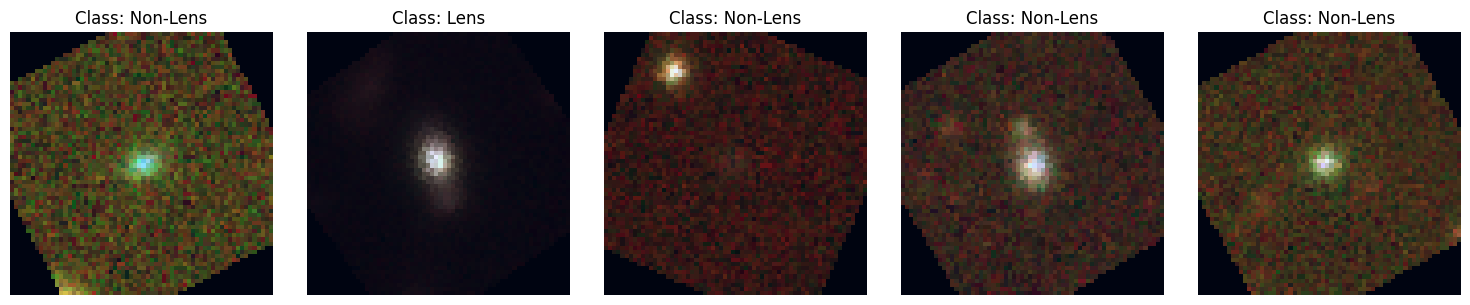

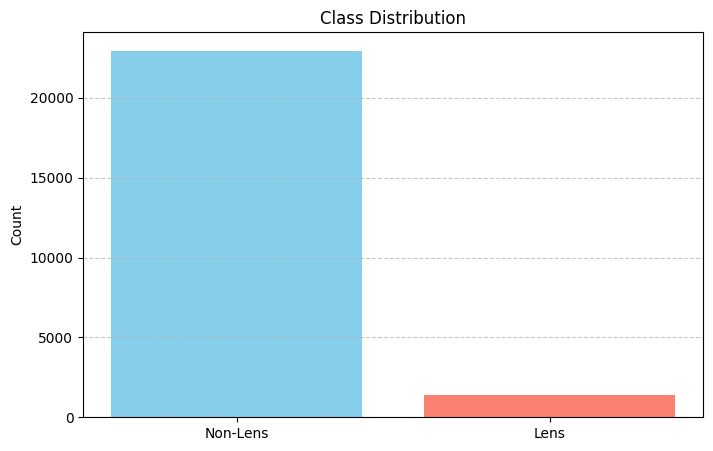

In [31]:
# set_seed(config['seed'])
# Visualize some samples
visualize_data(train_loader)

In [32]:
set_seed(config['seed'])
# Create model
model = create_model(config)

# Train model
if config['model_name'].startswith('dinov2'):
    trained_model, history = train_model_with_dinov2(model[0],model[1], train_loader, val_loader, config)
    trained_model = (model[0], trained_model)
else:
    trained_model, history = train_model(model, train_loader, val_loader, config)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


Created resnet50 model
Using bce loss
Epoch 1/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.1216 Acc: 0.9521


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0906 Acc: 0.9701 Precision: 0.8105 Recall: 0.6435 F1: 0.7174 ROC AUC: 0.9751

Epoch 2/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0979 Acc: 0.9630


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.1208 Acc: 0.9609 Precision: 0.7065 Recall: 0.5766 F1: 0.6350 ROC AUC: 0.9634

Epoch 3/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0929 Acc: 0.9637


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0696 Acc: 0.9734 Precision: 0.8147 Recall: 0.7103 F1: 0.7589 ROC AUC: 0.9824

Epoch 4/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0837 Acc: 0.9673


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0738 Acc: 0.9745 Precision: 0.8643 Recall: 0.6741 F1: 0.7574 ROC AUC: 0.9826

Epoch 5/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0805 Acc: 0.9693


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0715 Acc: 0.9714 Precision: 0.8715 Recall: 0.6045 F1: 0.7138 ROC AUC: 0.9848

Epoch 6/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0743 Acc: 0.9730


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0655 Acc: 0.9740 Precision: 0.8792 Recall: 0.6490 F1: 0.7468 ROC AUC: 0.9871

Epoch 7/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0713 Acc: 0.9729


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0653 Acc: 0.9781 Precision: 0.8343 Recall: 0.7855 F1: 0.8092 ROC AUC: 0.9864

Epoch 8/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0683 Acc: 0.9756


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0720 Acc: 0.9737 Precision: 0.7884 Recall: 0.7577 F1: 0.7727 ROC AUC: 0.9844

Epoch 9/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0660 Acc: 0.9749


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0644 Acc: 0.9740 Precision: 0.8880 Recall: 0.6407 F1: 0.7443 ROC AUC: 0.9885

Epoch 10/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0639 Acc: 0.9766


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0630 Acc: 0.9766 Precision: 0.8974 Recall: 0.6825 F1: 0.7753 ROC AUC: 0.9857

Epoch 11/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0611 Acc: 0.9769


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0662 Acc: 0.9763 Precision: 0.8525 Recall: 0.7242 F1: 0.7831 ROC AUC: 0.9859

Epoch 12/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0602 Acc: 0.9777


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0612 Acc: 0.9762 Precision: 0.8794 Recall: 0.6908 F1: 0.7738 ROC AUC: 0.9864

Epoch 13/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0591 Acc: 0.9778


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0656 Acc: 0.9757 Precision: 0.8505 Recall: 0.7131 F1: 0.7758 ROC AUC: 0.9850

Epoch 14/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0589 Acc: 0.9783


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0584 Acc: 0.9778 Precision: 0.9118 Recall: 0.6908 F1: 0.7861 ROC AUC: 0.9886

Epoch 15/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0581 Acc: 0.9781


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0868 Acc: 0.9684 Precision: 0.8646 Recall: 0.5515 F1: 0.6735 ROC AUC: 0.9807

Epoch 16/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0556 Acc: 0.9799


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0884 Acc: 0.9686 Precision: 0.9118 Recall: 0.5181 F1: 0.6607 ROC AUC: 0.9820

Epoch 17/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0545 Acc: 0.9793


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0562 Acc: 0.9791 Precision: 0.8412 Recall: 0.7967 F1: 0.8183 ROC AUC: 0.9891

Epoch 18/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0547 Acc: 0.9801


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.1023 Acc: 0.9637 Precision: 0.8920 Recall: 0.4373 F1: 0.5869 ROC AUC: 0.9802

Epoch 19/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0530 Acc: 0.9808


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0688 Acc: 0.9760 Precision: 0.7591 Recall: 0.8691 F1: 0.8104 ROC AUC: 0.9873

Epoch 20/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0534 Acc: 0.9806


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0545 Acc: 0.9799 Precision: 0.8455 Recall: 0.8078 F1: 0.8262 ROC AUC: 0.9890

Epoch 21/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0496 Acc: 0.9818


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0528 Acc: 0.9799 Precision: 0.8860 Recall: 0.7577 F1: 0.8168 ROC AUC: 0.9906

Epoch 22/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0500 Acc: 0.9821


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0506 Acc: 0.9824 Precision: 0.8387 Recall: 0.8691 F1: 0.8536 ROC AUC: 0.9918

Epoch 23/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0482 Acc: 0.9822


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0508 Acc: 0.9832 Precision: 0.8813 Recall: 0.8273 F1: 0.8534 ROC AUC: 0.9893

Epoch 24/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0495 Acc: 0.9813


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0469 Acc: 0.9842 Precision: 0.8790 Recall: 0.8496 F1: 0.8640 ROC AUC: 0.9915

Epoch 25/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0488 Acc: 0.9822


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0509 Acc: 0.9826 Precision: 0.8485 Recall: 0.8579 F1: 0.8532 ROC AUC: 0.9895

Epoch 26/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0464 Acc: 0.9829


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0508 Acc: 0.9831 Precision: 0.8855 Recall: 0.8189 F1: 0.8509 ROC AUC: 0.9907

Epoch 27/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0431 Acc: 0.9846


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0532 Acc: 0.9819 Precision: 0.8527 Recall: 0.8384 F1: 0.8455 ROC AUC: 0.9899

Epoch 28/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0458 Acc: 0.9821


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0508 Acc: 0.9822 Precision: 0.8659 Recall: 0.8273 F1: 0.8462 ROC AUC: 0.9900

Epoch 29/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0430 Acc: 0.9844


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0549 Acc: 0.9816 Precision: 0.8824 Recall: 0.7939 F1: 0.8358 ROC AUC: 0.9890

Epoch 30/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0419 Acc: 0.9849


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0477 Acc: 0.9824 Precision: 0.8962 Recall: 0.7939 F1: 0.8419 ROC AUC: 0.9918

Epoch 31/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0415 Acc: 0.9845


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0527 Acc: 0.9809 Precision: 0.9293 Recall: 0.7326 F1: 0.8193 ROC AUC: 0.9922

Epoch 32/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0408 Acc: 0.9848


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0446 Acc: 0.9852 Precision: 0.8789 Recall: 0.8691 F1: 0.8739 ROC AUC: 0.9928

Epoch 33/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0390 Acc: 0.9862


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0483 Acc: 0.9831 Precision: 0.8699 Recall: 0.8384 F1: 0.8539 ROC AUC: 0.9913

Epoch 34/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0395 Acc: 0.9859


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0473 Acc: 0.9855 Precision: 0.9021 Recall: 0.8468 F1: 0.8736 ROC AUC: 0.9900

Epoch 35/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0388 Acc: 0.9860


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0461 Acc: 0.9847 Precision: 0.8912 Recall: 0.8440 F1: 0.8670 ROC AUC: 0.9907

Epoch 36/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0356 Acc: 0.9870


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0495 Acc: 0.9837 Precision: 0.8846 Recall: 0.8329 F1: 0.8580 ROC AUC: 0.9904

Epoch 37/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0370 Acc: 0.9863


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0452 Acc: 0.9860 Precision: 0.8743 Recall: 0.8914 F1: 0.8828 ROC AUC: 0.9921

Epoch 38/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0355 Acc: 0.9868


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0487 Acc: 0.9844 Precision: 0.9286 Recall: 0.7967 F1: 0.8576 ROC AUC: 0.9920

Epoch 39/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0336 Acc: 0.9880


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0477 Acc: 0.9842 Precision: 0.8834 Recall: 0.8440 F1: 0.8632 ROC AUC: 0.9909

Epoch 40/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0332 Acc: 0.9876


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0446 Acc: 0.9842 Precision: 0.8470 Recall: 0.8942 F1: 0.8699 ROC AUC: 0.9913

Epoch 41/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0333 Acc: 0.9887


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0441 Acc: 0.9859 Precision: 0.8845 Recall: 0.8747 F1: 0.8796 ROC AUC: 0.9923

Epoch 42/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0321 Acc: 0.9885


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0438 Acc: 0.9859 Precision: 0.8957 Recall: 0.8607 F1: 0.8778 ROC AUC: 0.9934

Epoch 43/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0332 Acc: 0.9883


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0457 Acc: 0.9845 Precision: 0.8909 Recall: 0.8412 F1: 0.8653 ROC AUC: 0.9908

Epoch 44/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0324 Acc: 0.9883


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0458 Acc: 0.9862 Precision: 0.9179 Recall: 0.8412 F1: 0.8779 ROC AUC: 0.9913

Epoch 45/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0314 Acc: 0.9893


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0452 Acc: 0.9860 Precision: 0.9006 Recall: 0.8579 F1: 0.8787 ROC AUC: 0.9921

Epoch 46/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0311 Acc: 0.9896


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0438 Acc: 0.9854 Precision: 0.9042 Recall: 0.8412 F1: 0.8716 ROC AUC: 0.9921

Epoch 47/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0305 Acc: 0.9888


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0410 Acc: 0.9868 Precision: 0.8974 Recall: 0.8774 F1: 0.8873 ROC AUC: 0.9927

Epoch 48/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0297 Acc: 0.9899


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0449 Acc: 0.9852 Precision: 0.8991 Recall: 0.8440 F1: 0.8707 ROC AUC: 0.9923

Epoch 49/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0298 Acc: 0.9892


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0458 Acc: 0.9839 Precision: 0.8739 Recall: 0.8496 F1: 0.8616 ROC AUC: 0.9920

Epoch 50/50
----------


Training:   0%|          | 0/761 [00:00<?, ?it/s]

Train Loss: 0.0300 Acc: 0.9895


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

Val Loss: 0.0445 Acc: 0.9865 Precision: 0.9110 Recall: 0.8552 F1: 0.8822 ROC AUC: 0.9921

Best validation auc: 0.9934 achieved at epoch 42


Evaluating:   0%|          | 0/191 [00:00<?, ?it/s]

Accuracy: 0.9867
Precision: 0.9017
Recall: 0.8691
F1 Score: 0.8851
ROC AUC: 0.9927


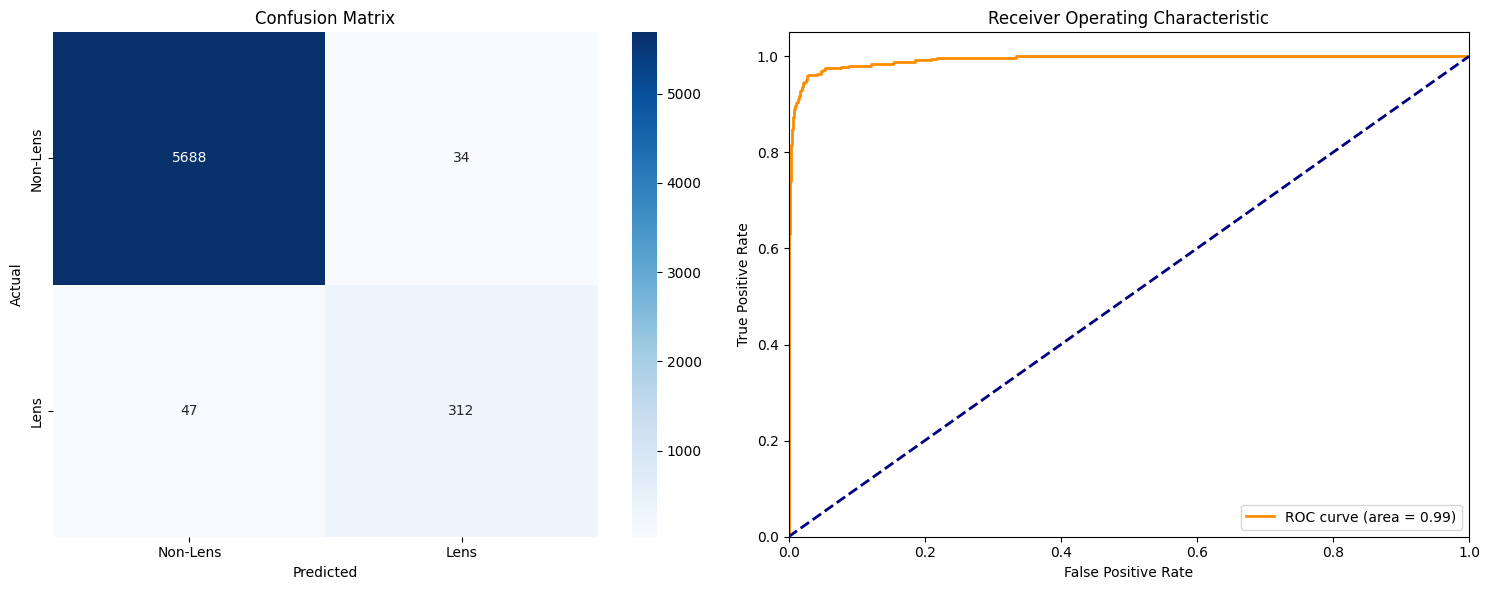

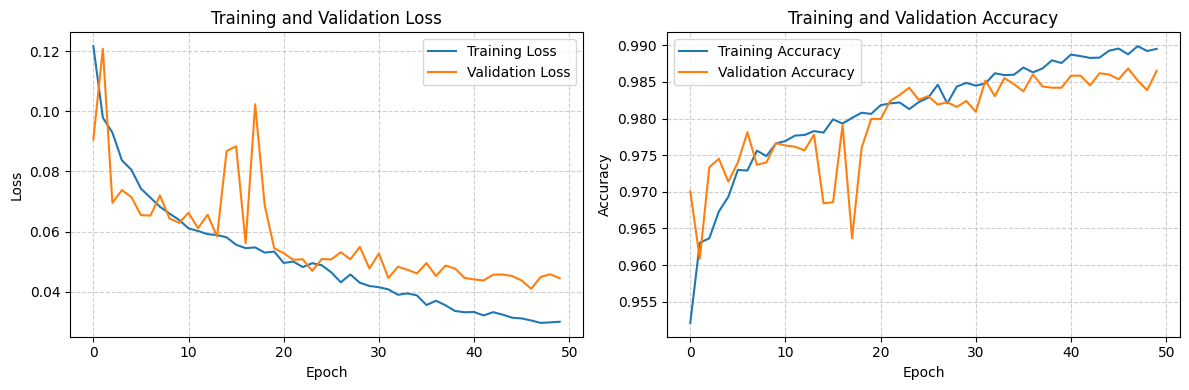

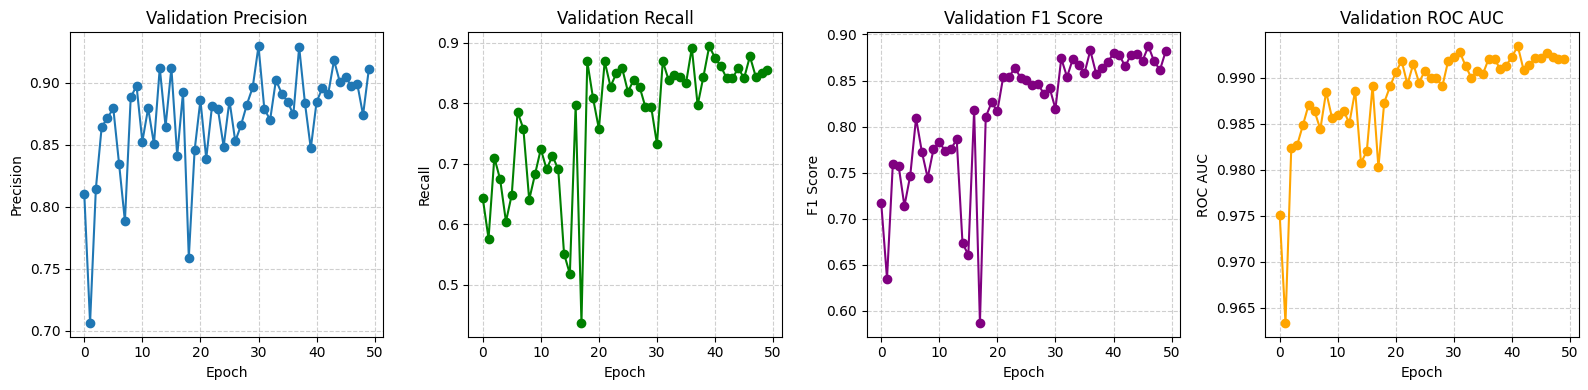

Model saved to ./saved_models/resnet50_20250328-133650_model.pth
Metadata saved to ./saved_models/resnet50_20250328-133650_metadata.pth


In [33]:
set_seed(config['seed'])
# Evaluate model
if config['model_name'].startswith('dinov2'):
    metrics = evaluate_model_with_dinov2(trained_model[0],trained_model[1], val_loader)
else:
    metrics = evaluate_model(trained_model, val_loader)

# Plot training history
plot_training_history(history)

# Save model
save_model(trained_model, config, metrics, history)

# Load model (example)
# loaded_model, metadata = load_model(
#     os.path.join(config['save_path'], 'resnet18_20250324-120000_model.pth'),
#     os.path.join(config['save_path'], 'resnet18_20250324-120000_metadata.pth')
# )

In [34]:
import os
count_test = {}
for dirname, _, filenames in os.walk('/kaggle/input/deeplense-specific-data/lens-finding/test_lenses'):
    count_test['test_lenses']=[os.path.join('/kaggle/input/deeplense-specific-data/lens-finding/test_lenses',f) for f in filenames]
for dirname, _, filenames in os.walk('/kaggle/input/deeplense-specific-data/lens-finding/test_nonlenses'):
    count_test['test_nonlenses']=[os.path.join('/kaggle/input/deeplense-specific-data/lens-finding/test_nonlenses',f) for f in filenames]

In [35]:
# Test set evaluation (Cell 14)
set_seed(config['seed'])

def prepare_test_data(test_lenses, test_nonlenses, config):
    """
    Prepare the test dataset
    
    Args:
        test_lenses (list): List of file paths to test lens data
        test_nonlenses (list): List of file paths to test non-lens data
        config (dict): Configuration parameters
        
    Returns:
        test_loader: DataLoader for test data
    """
    # Create file paths and labels lists
    test_file_paths = test_lenses + test_nonlenses
    test_labels = [1] * len(test_lenses) + [0] * len(test_nonlenses)
    
    # Use a simple normalization transform for test data (no augmentation)
    transform = transforms.Compose([
        transforms.Normalize(mean=config['mean'], std=config['std'])
    ])
    
    # Create the test dataset
    if config['model_name'].startswith('dinov2'):
        test_dataset = LensDataset(test_file_paths, test_labels, transform=None)
    else:
        test_dataset = LensDataset(test_file_paths, test_labels, transform=transform)
    
    # Create data loader
    test_loader = DataLoader(
        test_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False, 
        num_workers=config['num_workers'],
        pin_memory=True
    )
    
    print(f"Test samples: {len(test_dataset)}")
    print(f"Lens samples: {len(test_lenses)}")
    print(f"Non-lens samples: {len(test_nonlenses)}")
    
    return test_loader

def evaluate_on_test_set(model, test_lenses, test_nonlenses, config):
    """
    Evaluate a trained model on the test set
    
    Args:
        model: Trained PyTorch model
        test_lenses: List of lens test file paths
        test_nonlenses: List of non-lens test file paths
        config: Configuration dictionary
        
    Returns:
        test_metrics: Dictionary of test metrics
    """
    print("Evaluating model on test set...")
    
    # Prepare test data
    test_loader = prepare_test_data(test_lenses, test_nonlenses, config)
    
    # Evaluate on test data
    if config['model_name'].startswith('dinov2'):
        test_metrics = evaluate_model_with_dinov2(model[0],model[1], test_loader)
    else:
        test_metrics = evaluate_model(model, test_loader)
    
    # Print summary
    print("\nTest Set Evaluation Summary:")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print(f"ROC AUC: {test_metrics['roc_auc']:.4f}")
    
    return test_metrics

Evaluating model on test set...
Test samples: 19650
Lens samples: 195
Non-lens samples: 19455


Evaluating:   0%|          | 0/615 [00:00<?, ?it/s]

Accuracy: 0.9916
Precision: 0.5472
Recall: 0.8615
F1 Score: 0.6693
ROC AUC: 0.9910


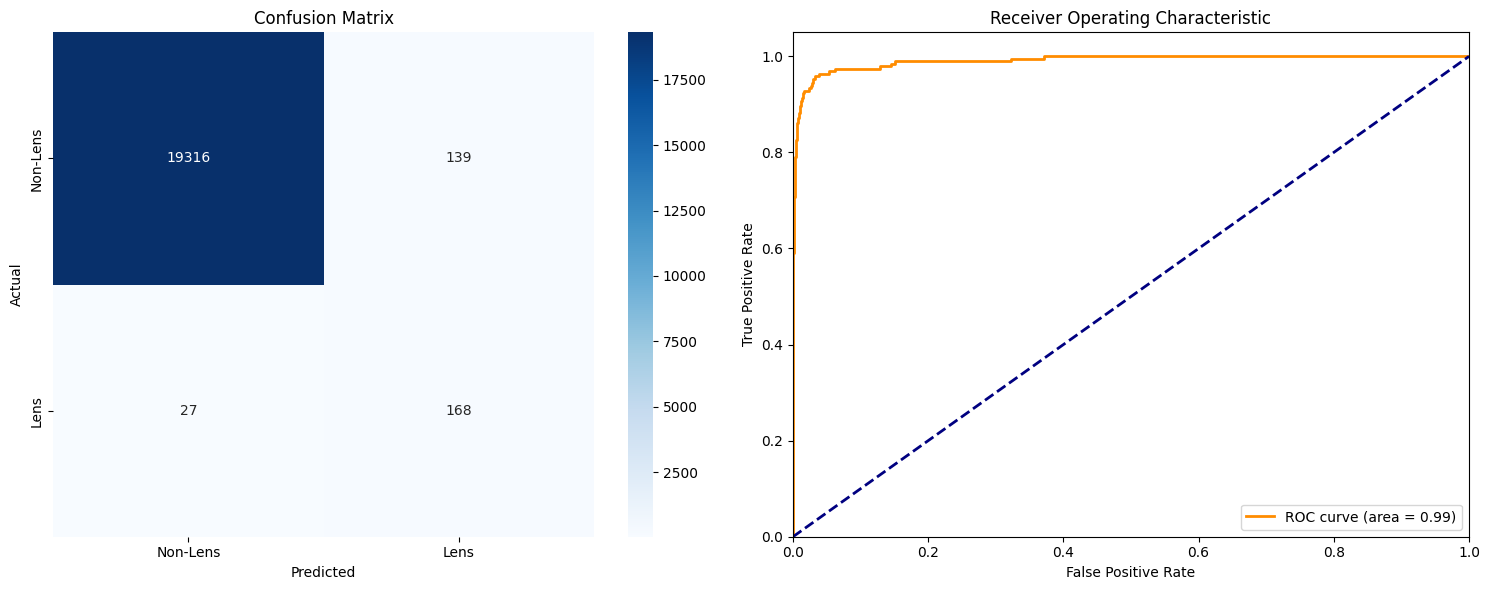


Test Set Evaluation Summary:
Accuracy: 0.9916
Precision: 0.5472
Recall: 0.8615
F1 Score: 0.6693
ROC AUC: 0.9910


In [36]:
set_seed(config['seed'])
# Example usage:
test_dict = count_test

test_metrics = evaluate_on_test_set(trained_model, 
                                    test_dict['test_lenses'], 
                                    test_dict['test_nonlenses'],
                                    config)

In [37]:
# Full training pipeline (Cell 12)
set_seed(config['seed'])

def run_full_pipeline(data_dict, config):
    """
    Run the full training pipeline
    
    Args:
        data_dict (dict): Dictionary with 'train_lenses' and 'train_nonlenses' keys
        config (dict): Configuration parameters
    """
    # Prepare data
    train_loader, val_loader = prepare_data(
        data_dict['train_lenses'], 
        data_dict['train_nonlenses'], 
        config
    )
    
    # Visualize some samples
    visualize_data(train_loader)
    
    # Create model
    model = create_model(config)
    
    # Train model
    trained_model, history = train_model(model, train_loader, val_loader, config)
    
    # Evaluate model
    metrics = evaluate_model(trained_model, val_loader)
    
    # Plot training history
    plot_training_history(history)
    
    # Save model
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    save_model(trained_model, config, metrics, history, 
               filename=f"{config['model_name']}_{timestamp}")
    
    return trained_model, metrics, history

In [38]:
# Entry point for manual execution (Cell 13)
# set_seed(config['seed'])

# # Sample usage (replace with your actual data)
# data_dict = count

# # Run the full training pipeline
# model, metrics, history = run_full_pipeline(data_dict, config)

# print("Training complete!")